## Cluster games according to game metadata and compare against actual bundles

### Step 1: Clean the dataset

The raw dataset 'bundle_data.json' is not in valid JSON format. Following steps are required to clean the raw file:
- For each line:
  - replace the single quotes with double quotes
  - After the first step, the field "item_name" has double quotes which should be single quote. So to tackle this, find those indexes and replace the double quotes with single quotes
  
- Example raw line:
  - {'bundle_final_price': '$66.46', 'bundle_url': 'http://store.steampowered.com/bundle/450/?utm_source=SteamDB&utm_medium=SteamDB&utm_campaign=SteamDB%20Bundles%20Page', 'bundle_price': '$73.86', 'bundle_name': 'Dharker Studio"s 2015 Complete', 'bundle_id': '450', 'items': [{'genre': 'Action, Indie', 'item_id': '396620', 'discounted_price': '$0.99', 'item_url': 'http://store.steampowered.com/app/396620', 'item_name': 'Quantum Flux - Soundtrack'}], 'bundle_discount': '10%'}

- Example cleaned line:
  - {"bundle_final_price": "$66.46", "bundle_url": "http://store.steampowered.com/bundle/450/?utm_source=SteamDB&utm_medium=SteamDB&utm_campaign=SteamDB%20Bundles%20Page", "bundle_price": "$73.86", "bundle_name": "Dharker Studio 2015 Complete", "bundle_id": "450", "items": [{"genre": "Action, Indie", "item_id": "396620", "discounted_price": "$0.99", "item_url": "http://store.steampowered.com/app/396620", "item_name": "Quantum Flux - Soundtrack"}], "bundle_discount": "10%"}

In [ ]:
import re
def clean_bundle_data():

    with open("/Users/akshay/Downloads/bundle_data.json", "r") as raw_input:
        with open("/Users/akshay/Downloads/bundle_data_cleaned.json", "w") as cleaned_file:
            try:
                for line in raw_input:
                    withoutSingleQuotes = line.replace('\'', '\"')
                    main_item_name_indexes = [m.start() for m in re.finditer("\"item_name\"", withoutSingleQuotes)]
                    for main_item_name_index in main_item_name_indexes:
                        main_item_name_index = main_item_name_index + 14
                        current_brace_index = withoutSingleQuotes[main_item_name_index:].find("}")
                        temp = withoutSingleQuotes[main_item_name_index: main_item_name_index + current_brace_index - 1]
                        repeatingDoubleQuotesIndexes = [m.start() for m in re.finditer("\"", temp)]
                        for i in repeatingDoubleQuotesIndexes:
                            toReplaceIndex = main_item_name_index + i
                            withoutSingleQuotes = withoutSingleQuotes[:toReplaceIndex] + "'" + withoutSingleQuotes[toReplaceIndex + 1:]


                    main_bundle_name_indexes = [m.start() for m in re.finditer("\"bundle_name\"", withoutSingleQuotes)]
                    for main_bundle_name_index in main_bundle_name_indexes:
                        main_bundle_name_index = main_bundle_name_index + 16
                        current_bid_index = withoutSingleQuotes[main_bundle_name_index:].find("bundle_id")
                        temp = withoutSingleQuotes[main_bundle_name_index: main_bundle_name_index + current_bid_index - 4]
                        repeatingDoubleQuotesIndexes = [m.start() for m in re.finditer("\"", temp)]
                        for i in repeatingDoubleQuotesIndexes:
                            toReplaceIndex = main_bundle_name_index + i
                            withoutSingleQuotes = withoutSingleQuotes[:toReplaceIndex] + "'" + withoutSingleQuotes[toReplaceIndex + 1:]
                    withoutSingleQuotes = withoutSingleQuotes.replace("\\", "")
                    cleaned_file.write(withoutSingleQuotes)
            except:
                pass
if __name__ == "__main__":
    clean_bundle_data()

### Step 2. Prepare the dataset

- For this analysis, we will start with the preprocessed dataset "item-genre-spec.csv". This dataset has all the categorical values, hence usual clustering algorithms like K Means are not applicable in this scenario as they work better for continuous variables.

In [121]:
import pandas as pd
from kmodes.kmodes import KModes
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [122]:
items_df = pd.read_csv("/Users/akshay/sjsu-cmpe-256-group-project/experiment3/item-genre-spec.csv", sep=",")

items_df.head()

,item_id,publisher,developer,genre_strategy,genre_animation_&amp;_modeling,genre_photo_editing,genre_software_training,genre_sports,genre_web_publishing,genre_accounting,...,spec_steam_workshop,spec_multi-player,spec_online_co-op,spec_downloadable_content,spec_stats,spec_mods,spec_captions_available,spec_mods_(require_hl1),spec_single-player,spec_steam_trading_cards
0,761140,Kotoshiro,Kotoshiro,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,643980,"Making Fun, Inc.",Secret Level SRL,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,1
2,670290,Poolians.com,Poolians.com,0,0,0,0,1,0,0,...,0,1,0,0,1,0,0,0,1,0
3,767400,u5f7cu5cb8u9886u57df,u5f7cu5cb8u9886u57df,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,772540,Trickjump Games Ltd,Trickjump Games Ltd,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [123]:
len(items_df['developer'].unique())

10234

In [124]:
len(items_df['publisher'].unique())

7706

As we can see, the distinct values for developer and publisher are quite high and all other columns are binary categorical features. Since this won't add value to the analysis, we will remove those features

In [125]:
items_df.drop(['item_id', 'developer', 'publisher'], axis=1, inplace=True)

In [126]:
items_df.shape

(29941, 53)

In [127]:
items_df.head()

,genre_strategy,genre_animation_&amp;_modeling,genre_photo_editing,genre_software_training,genre_sports,genre_web_publishing,genre_accounting,genre_free_to_play,genre_indie,genre_utilities,...,spec_steam_workshop,spec_multi-player,spec_online_co-op,spec_downloadable_content,spec_stats,spec_mods,spec_captions_available,spec_mods_(require_hl1),spec_single-player,spec_steam_trading_cards
0,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1,1,0,0,0,0,0,0,1,1,0,...,0,1,0,0,0,0,0,0,1,1
2,0,0,0,0,1,0,0,1,1,0,...,0,1,0,0,1,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


### Step 3: Create clusters using KMode Algorithm

- KMode is a clustering algorithm which can cluster items based on categorical variables, not just continuous variables. There are two methods to calculate the distances between the vectors in KMode algorithm: Huang and Cao. We will compute costs for both these types for different number of clusters.

In [ ]:
clustering_costs_huang = []
for i in list(range(1,30,5)):
    kmode = KModes(n_clusters=i, init = "Huang", verbose=1, n_jobs=-1)
    kmode.fit_predict(items_df)
    clustering_costs_huang.append(kmode.cost_)

- Create an Elbow Curve graph to determine the optimum number of clusters to form

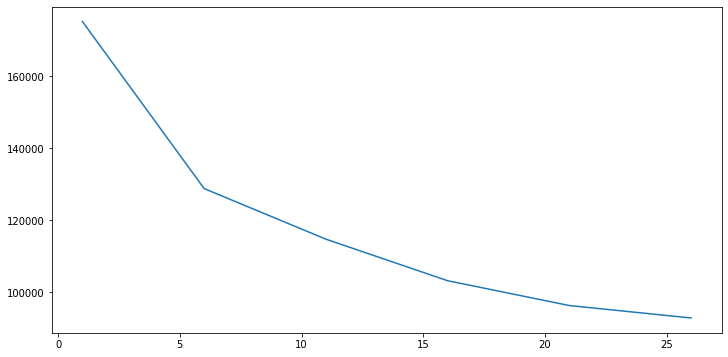

In [187]:
plt.figure(figsize=(12, 6))
y = np.array([i for i in range(1,30,5)])
plt.plot(y,clustering_costs_huang)

In [ ]:
clustering_costs_cao = []
for i in list(range(1,30,5)):
    kmode = KModes(n_clusters=i, init = "Cao", verbose=1, n_jobs=-1)
    kmode.fit_predict(items_df)
    clustering_costs_cao.append(kmode.cost_)

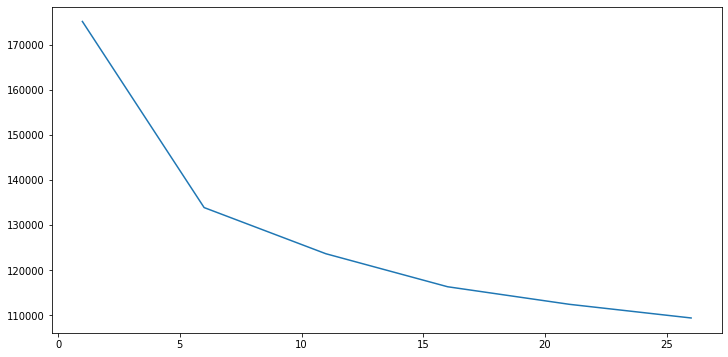

In [188]:
plt.figure(figsize=(12, 6))
y = np.array([i for i in range(1,30,5)])
plt.plot(y,clustering_costs_cao)

- As evidenced from the two Elbow Curve graphs, number of clusters is around 7.
- We will form 7 clusters using both the "Huang" and "Cao" metric, and analyze the number of items in each cluster

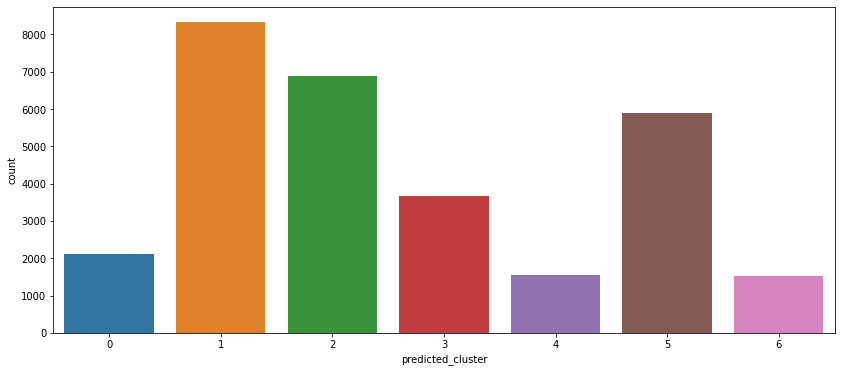

In [137]:
kmodes_model_huang = KModes(n_clusters=7, init = "Huang", verbose=1, n_jobs=-1)
game_clusters_huang = kmodes_model_huang.fit_predict(items_df)
game_clusters_huang_df = pd.DataFrame(game_clusters_huang)
game_clusters_huang_df.columns = ['predicted_cluster']
plt.figure(figsize=(14, 6))
ax = sns.countplot(x="predicted_cluster", data=game_clusters_huang_df)

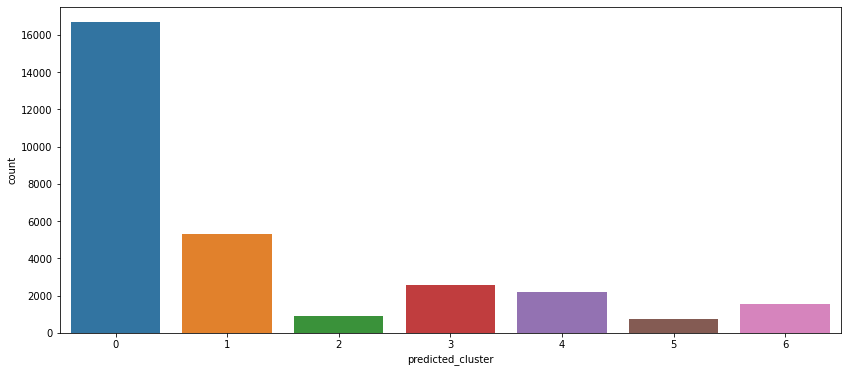

In [138]:
kmodes_model_cao = KModes(n_clusters=7, init = "Cao", verbose=1, n_jobs=-1)
game_clusters_cao = kmodes_model_cao.fit_predict(items_df)
game_clusters_cao_df = pd.DataFrame(game_clusters_cao)
game_clusters_cao_df.columns = ['predicted_cluster']
plt.figure(figsize=(14, 6))
ax = sns.countplot(x="predicted_cluster", data=game_clusters_cao_df)

- We can see that the clusters are more equitably distributed when we use the "Huang" metric for calculating the distance between vectors. Therefore, we will use the clusters formed from the kmodes_model_huang.
- We combine the predicted_cluster dataframe with our original items dataframe

In [132]:
game_clusters_df = pd.DataFrame(game_clusters_huang)
game_clusters_df.columns = ['predicted_cluster']
combined_df = pd.concat([items_df, game_clusters_df], axis = 1)
combined_df.head(10)

,genre_strategy,genre_animation_&amp;_modeling,genre_photo_editing,genre_software_training,genre_sports,genre_web_publishing,genre_accounting,genre_free_to_play,genre_indie,genre_utilities,...,spec_multi-player,spec_online_co-op,spec_downloadable_content,spec_stats,spec_mods,spec_captions_available,spec_mods_(require_hl1),spec_single-player,spec_steam_trading_cards,predicted_cluster
0,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,5
1,1,0,0,0,0,0,0,1,1,0,...,1,0,0,0,0,0,0,1,1,1
2,0,0,0,0,1,0,0,1,1,0,...,1,0,0,1,0,0,0,1,0,2
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,2
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,5
5,0,0,0,0,1,0,0,1,1,0,...,1,0,1,0,0,0,0,1,1,0
6,0,0,0,0,1,0,0,1,1,0,...,1,0,1,0,0,0,0,1,1,0
7,0,0,0,0,1,0,0,1,1,0,...,1,0,1,0,0,0,0,1,1,0
8,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,2
9,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,5


- The following figure shows the distribution of the variable "spec_downloadable_content" across the different clusters. We can see that this variable is uniformly distributed across all clusters.

### Step 4: Analyze the similarity of generated clusters with actual bundles

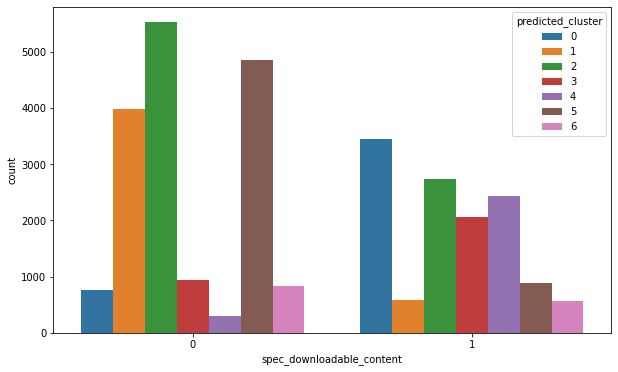

In [136]:
plt.figure(figsize=(10, 6))
sns.countplot(x=combined_df['spec_downloadable_content'],order=combined_df['spec_downloadable_content'].value_counts().index,hue=combined_df['predicted_cluster'])
plt.show()

- Print the contents of each cluster to view the most closely related genres and specs 

In [139]:
kmodes_n = kmodes_model_huang.cluster_centroids_
shape = kmodes_n.shape
for i in range(shape[0]):
    print("\ncluster " + str(i) + ": ")
    cent = kmodes_n[i,:]
    for j in items_df.columns[np.nonzero(cent)]:
        print(j)


cluster 0: 
genre_indie
genre_action
spec_full_controller_support
spec_steam_achievements
spec_shared/split_screen
spec_multi-player
spec_single-player
spec_steam_trading_cards

cluster 1: 
genre_indie
spec_steam_cloud
spec_steam_achievements
spec_single-player
spec_steam_trading_cards

cluster 2: 
spec_multi-player
spec_downloadable_content
spec_single-player

cluster 3: 
genre_indie
genre_simulation
spec_steam_achievements
spec_single-player

cluster 4: 
genre_action
spec_steam_cloud
spec_steam_achievements
spec_steam_leaderboards
spec_co-op
spec_multi-player
spec_downloadable_content
spec_single-player

cluster 5: 
spec_single-player

cluster 6: 
genre_action
genre_adventure
spec_full_controller_support
spec_steam_achievements
spec_downloadable_content
spec_single-player
spec_steam_trading_cards


- Load the initial dataframe to get the "item_id" column merged with our combined dataframe

In [167]:
import json
item_ids = pd.read_csv("/Users/akshay/sjsu-cmpe-256-group-project/experiment3/item-genre-spec.csv", sep=",")["item_id"]
item_with_clusters = pd.concat([item_ids, combined_df], axis = 1)
item_with_clusters.head()

,item_id,genre_strategy,genre_animation_&amp;_modeling,genre_photo_editing,genre_software_training,genre_sports,genre_web_publishing,genre_accounting,genre_free_to_play,genre_indie,...,spec_multi-player,spec_online_co-op,spec_downloadable_content,spec_stats,spec_mods,spec_captions_available,spec_mods_(require_hl1),spec_single-player,spec_steam_trading_cards,predicted_cluster
0,761140,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,5
1,643980,1,0,0,0,0,0,0,1,1,...,1,0,0,0,0,0,0,1,1,1
2,670290,0,0,0,0,1,0,0,1,1,...,1,0,0,1,0,0,0,1,0,2
3,767400,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,2
4,772540,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,5


- Now, we can analyze each game bundle in the following manner:
  - For each item in the bundle, get which "cluster" the item belongs to
  - Check what percentage of items in the bundle belong to the same "cluster"

In [185]:
item_found = 0
item_missing = 0
cluster_bundle_match = pd.DataFrame(columns=['match_score'])
import statistics

with open("/Users/akshay/Downloads/bundle_data_cleaned.json", "r") as cleaned_file:
    for line in cleaned_file:
        try:
            json_obj = json.loads(line)
            items = json_obj['items']
            predictions = []
            for item in items:
                item_id = int(item["item_id"])
                if item_id in item_ids.values:
                    item_found = item_found + 1
                    cluster_prediction = int(item_with_clusters.loc[item_with_clusters["item_id"] == item_id]["predicted_cluster"])
                    predictions.append(cluster_prediction)
                else:
                    item_missing = item_missing + 1
            mode = statistics.mode(predictions)
            match_score = float(predictions.count(mode)/len(predictions))*100
            print(predictions, match_score)
            cluster_bundle_match = cluster_bundle_match.append({'match_score': round(match_score)}, ignore_index=True)
        except:
            pass


[1, 1, 2, 1, 1, 5, 5, 5, 5] 44.44444444444444
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 100.0
[2, 2, 2] 100.0
[2, 2, 2] 100.0
[1, 0] 50.0
[1] 100.0
[5, 5] 100.0
[5, 5, 5, 5, 5] 100.0
[1, 1, 1, 5] 75.0
[1, 0] 50.0
[2, 2] 100.0
[1, 1] 100.0
[5, 5, 5, 1, 1, 2] 50.0
[3, 3, 3, 1] 75.0
[1, 3, 3, 1, 1] 60.0
[2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 94.44444444444444
[2, 2, 3] 66.66666666666666
[5, 5] 100.0
[3, 3, 3] 100.0
[5, 3] 50.0
[1, 5, 4, 4, 4, 4, 4, 4, 4] 77.77777777777779
[5, 4, 4, 4, 4, 4, 4, 4] 87.5
[2] 100.0
[3] 100.0
[5, 5, 5] 100.0
[2, 6, 6, 2, 1] 40.0
[3, 5] 50.0
[5, 2] 50.0
[1] 100.0
[1, 1] 100.0
[6, 6] 100.0
[5, 0] 50.0
[1, 1] 100.0
[2, 2, 2] 100.0
[1, 2] 50.0
[5, 1, 5, 1, 1] 60.0
[1, 5, 5] 66.66666666666666
[1, 2] 50.0
[1, 1] 100.0
[2, 0] 50.0
[1, 1, 1, 1] 100.0
[3, 5] 50.0
[2, 2] 100.0
[3, 3] 100.0
[3, 3] 100.0
[5] 100.0
[5] 100.0
[1, 1] 100.0
[1, 1] 100.0
[1, 4, 4, 4] 75.0
[0, 0] 100.0
[5, 3] 50.0
[0, 0] 100.0
[1] 100.0

- The above output lists all the bundles with corresponding items and which "cluster" does the item belong to.
- Cluster match score is also printed alongside to represent the confidence of the matching
- The following graph plots the frequency of the cluster match_score for each bundle

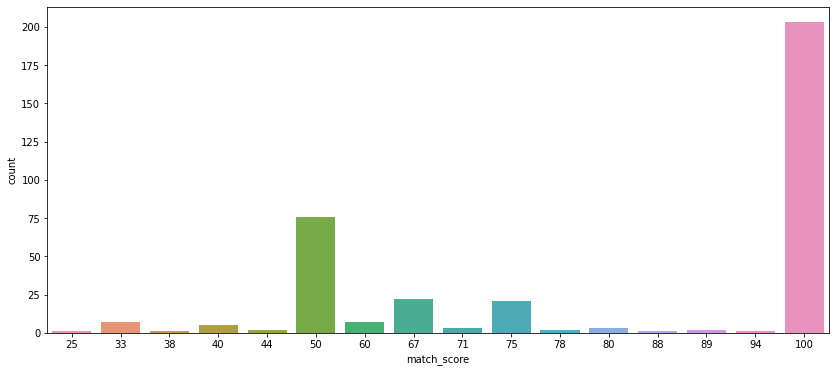

In [186]:
plt.figure(figsize=(14, 6))
ax = sns.countplot(x="match_score", data=cluster_bundle_match)

- From the above graph, it is evident that most of the bundles were matched to the same cluster with confidence of over 50%